In [462]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import patheffects

In [463]:
import numpy as np
import pandas as pd

In [464]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [465]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct
from sqlalchemy import and_

In [466]:
# Creating an engine object of the hawaii database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# Listing the tables in the database
engine.table_names()

['measurement', 'station']

In [467]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [468]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [469]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
# Listing the columns of tables
print(f"Measurement Table fields {Measurement.__table__.columns.keys()}")
print(f"Station Table fields {Station.__table__.columns.keys()}")

Measurement Table fields ['id', 'station', 'date', 'prcp', 'tobs']
Station Table fields ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [470]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

**Precipitation Analysis**

In [471]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_measurement_date = dt.datetime.strptime(session.query(func.max(Measurement.date))\
                                             .first()[0], '%Y-%m-%d').date()
last_12_months = last_measurement_date - dt.timedelta(days = 365)
print(f"Last measurement date is {last_measurement_date}")
print(f"Date 12 months before is {last_12_months}")

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp)\
                        .filter(Measurement.date >= last_12_months)\
                        .all()

results[:5]

Last measurement date is 2017-08-23
Date 12 months before is 2016-08-23


[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [472]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
daily_prcp_data = pd.DataFrame(results, columns=["date", "precipitation"]).set_index("date").sort_index()
daily_prcp_data.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


[]

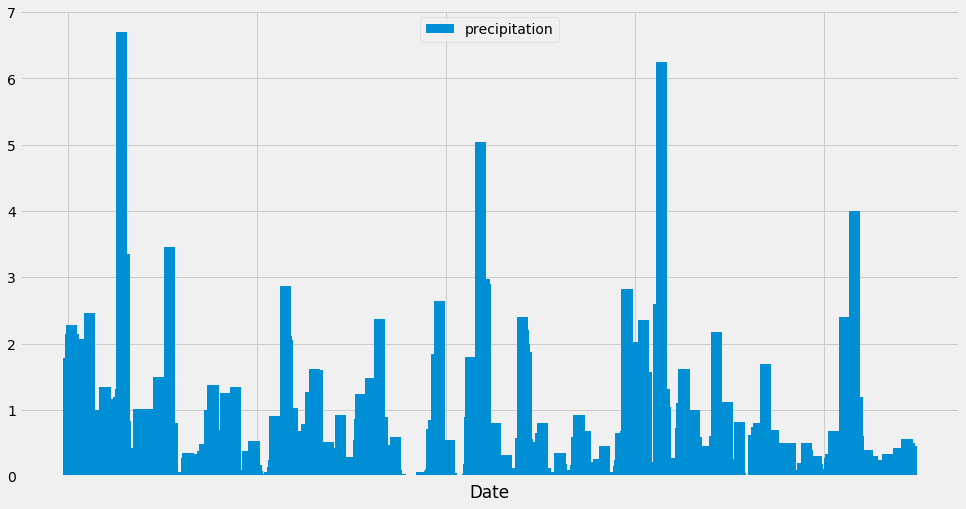

In [473]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,8))
#bar_plot = daily_prcp_data.plot(kind="bar", ax =ax)
x = np.arange(0,len(daily_prcp_data))
barplot = plt.bar(x,daily_prcp_data["precipitation"], width=30, fill=True,  joinstyle ='round', capstyle = 'round')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_xlabel("Date")
plt.legend(daily_prcp_data.columns,loc='upper center')
plt.plot()


![precipitation](Images/precipitation.png)

In [474]:
# Use Pandas to calcualte the summary statistics for the precipitation data
daily_prcp_data.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


**Station Analysis**

*Total Number of Stations*

In [475]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Measurement.station).distinct(Measurement.station).count()
print(f"Number of stations {stations_count}")


Number of stations 9


*Most Active Stations*

In [476]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_st = func.count(Measurement.station)
results1 = session.query(Measurement.station, count_st)\
                     .group_by(Measurement.station)\
                     .order_by(count_st.desc())\
                     .all()
#[print(f"{row[0]}, {row[1]}") for row in results]
results1


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [477]:
# Finding the most active station
active_station_id = results[0][0]
print(active_station_id)

2016-08-23


In [478]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stmt = [func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)]
results_3 = session.query(*stmt)\
             .filter(Measurement.station == active_station_id)\
             .first()
print(f"Temperature Detils for most active station {active_station_id}")
print(f"Max temperature {result[0]} Min temperature {results_3[1]} Avg temperature {results_3[2]}")

Temperature Detils for most active station 2016-08-23
Max temperature 54.0 Min temperature None Avg temperature None


*Analysis of 12 months of temperature observation data (tobs)*

In [479]:
# Choose the station with the highest number of temperature observations.

max_temp_stmt = func.count(distinct(Measurement.tobs))
results_4 = session.query(Measurement.station,max_temp_stmt)\
             .group_by(Measurement.station)\
             .order_by(max_temp_stmt.desc())\
             .all()
#[print(f"{row[0]}, {row[1]}") for row in results]
print("Highest number of temperature observations")
results_4


Highest number of temperature observations


[('USC00511918', 34),
 ('USC00519281', 31),
 ('USC00519397', 30),
 ('USC00519523', 30),
 ('USC00517948', 28),
 ('USC00513117', 27),
 ('USC00516128', 27),
 ('USC00514830', 26),
 ('USC00518838', 25)]

In [480]:
# Finding station with highest number of temperature observations
station_max_temp_count = results_4[0][0]
print(f"Station with Highest NUmber of Observations is {station_max_temp_count}")

Station with Highest NUmber of Observations is USC00511918


In [481]:
# Finding the latest date and last 12 month date
station_max_date = session.query(func.max(Measurement.date))\
                              .filter(Measurement.station == 'USC00519281')\
                              .first()


station_max_date = dt.datetime.strptime(station_max_date[0], '%Y-%m-%d').date()
station_last_12_months = station_max_date - dt.timedelta(days = 365)
print(station_max_date)
print(station_last_12_months)

2017-08-18
2016-08-18


In [482]:
# Query the last 12 months of temperature observation data for this station
# Creating Dataframe
results_5 = session.query(Measurement.tobs)\
                    .filter(and_(Measurement.date > station_last_12_months, Measurement.station == 'USC00519281'))\
                    .all()
temp_data_12_months = pd.DataFrame(results_5)
temp_data_12_months.head()

,tobs
0,79.0
1,81.0
2,79.0
3,78.0
4,77.0


[]

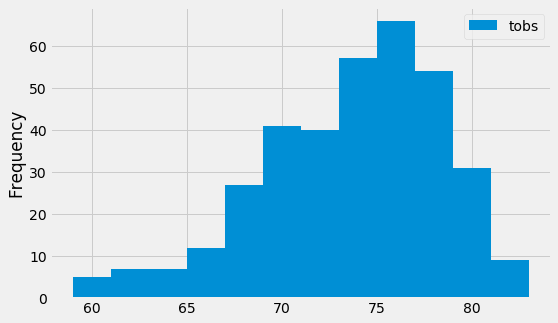

In [483]:
# plot the results as a histogram
fig, ax = plt.subplots(figsize=(8,5))
hist = plt.hist(x= temp_data_12_months["tobs"], bins=12)
ax.set_ylabel("Frequency")
plt.legend(temp_data_12_months.columns)

plt.plot()

# Exploratory Temperature Analysis

In [484]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [485]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Using below dates as start date and end date of trips
end_date = dt.datetime.strptime('2017-07-01', "%Y-%m-%d").date()
start_date = end_date - dt.timedelta(days=12)
#start_date = dt.datetime.strptime('2012-02-28', "%Y-%m-%d").date()
#end_date = dt.datetime.strptime('2012-03-05', "%Y-%m-%d").date()
print(f"Trip Start date {start_date}, End date {end_date}")
print(f"Current trip temp details Min, Avg, Max {calc_temps(start_date,end_date)}")


Trip Start date 2017-06-19, End date 2017-07-01
Current trip temp details Min, Avg, Max [(71.0, 77.07594936708861, 82.0)]


In [486]:
# Calculating the start and end dates in last year.
prev_year_start_date = start_date - dt.timedelta(days=365)
prev_year_end_date = end_date - dt.timedelta(days=365)
print(f"Trip Start date in last year {prev_year_start_date}, End date {prev_year_end_date}")
result_6 = calc_temps(prev_year_start_date, prev_year_end_date)
t_min , avg_temp, t_max = result_6[0]
print(f"Previous year, temp details Min, Avg, Max {calc_temps(prev_year_start_date, prev_year_end_date)}")
# print(f"{t_min} {avg_temp} {t_max} ")

Trip Start date in last year 2016-06-19, End date 2016-07-01
Previous year, temp details Min, Avg, Max [(71.0, 76.55294117647058, 81.0)]


[]

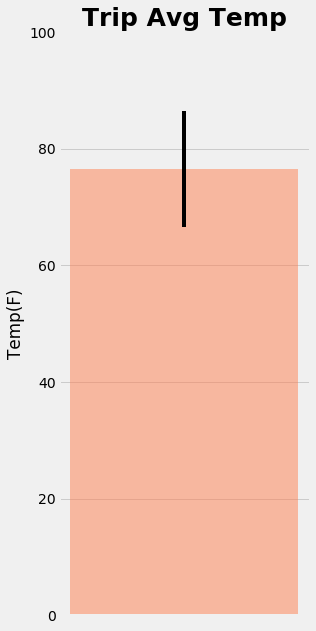

In [487]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(4,10))
xpos = np.arange(0,len(result_6))
errorbar = ax.bar(x=xpos , height= avg_temp, yerr = t_max-t_min,
                      alpha = 0.5, ecolor='black', color='Coral', width =0.1)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_title("Trip Avg Temp", fontweight="bold", fontsize=25)
ax.set_ylabel("Temp(F)")
ax.set_ylim(0,100)
ax.xaxis.grid(False)
ax.set_xticks(xpos)
#plt.tight_layout()
plt.plot()


# Daily Rainfall Average

In [488]:
# Trip start and end dates in last year
print(f"Trip Start date in last year {prev_year_start_date}, End date {prev_year_end_date}")

Trip Start date in last year 2016-06-19, End date 2016-07-01


In [489]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
sel1 = func.sum(Measurement.prcp)
results_7 = session.query(*sel, sel1)\
              .filter(Station.station == Measurement.station)\
              .filter(and_(Measurement.date >= prev_year_start_date, Measurement.date <= prev_year_end_date))\
              .group_by(Station.station)\
              .order_by(sel1.desc())\
              .all()
print(results_7)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.789999999999999), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.6199999999999997), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.4600000000000002), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.24), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.32999999999999996), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.1), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.07999999999999999)]


In [490]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [491]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax

    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [492]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Function to find dates between 2 dates
def daterange(date1, date2):
    """Dates in a range
       Args:
               start, end  : in date format
       Returns:
               Dates between a start and end dates
       
    """
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + dt.timedelta(n)
        
# Use the start and end date to create a range of dates
# Set the start and end date of the trip
print(f"Trip Start date {start_date}, End date {end_date}")


# Stip off the year and save a list of %m-%d strings
date_list = []

for d in daterange(start_date, end_date):
    date_list.append(d.strftime("%m-%d"))


# Loop through the list of %m-%d strings and calculate the normals for each date
temp_min = []
temp_avg = []
temp_max = []

for i in range(len(date_list)):
   temp_min.append(daily_normals(date_list[i])[0][0])
   temp_avg.append(daily_normals(date_list[i])[0][1])
   temp_max.append(daily_normals(date_list[i])[0][2])


Trip Start date 2017-06-19, End date 2017-07-01


In [493]:
np.arange(np.datetime64(start_date),np.datetime64(end_date)+1)

array(['2017-06-19', '2017-06-20', '2017-06-21', '2017-06-22',
       '2017-06-23', '2017-06-24', '2017-06-25', '2017-06-26',
       '2017-06-27', '2017-06-28', '2017-06-29', '2017-06-30',
       '2017-07-01'], dtype='datetime64[D]')

In [494]:
trip_normals_data = pd.DataFrame({'date': np.arange(np.datetime64(start_date),np.datetime64(end_date)+1),
                                  'tmin' : temp_min,
                                  'tavg' : temp_avg,
                                  'tmax' : temp_max                                  
                                 }).set_index("date")
trip_normals_data.head()

,tmin,tavg,tmax
date,,,
2017-06-19,70.0,75.440678,82.0
2017-06-20,68.0,73.964912,85.0
2017-06-21,68.0,74.758621,82.0
2017-06-22,69.0,75.157895,81.0
2017-06-23,68.0,74.543860,80.0


In [495]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


[]

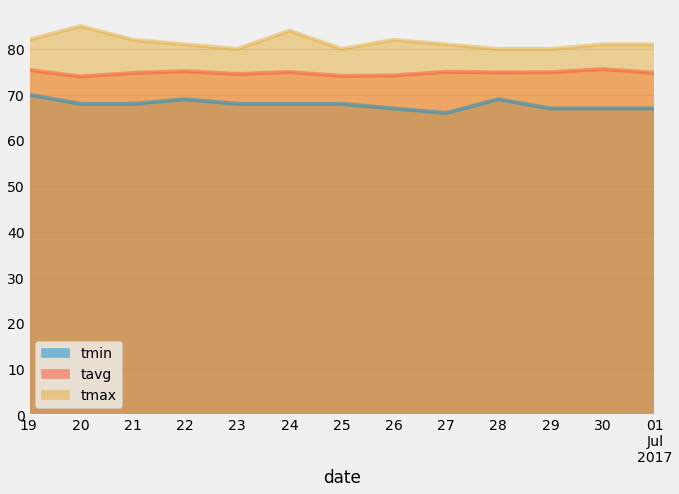

In [496]:
# Plotting an area plot
fig, ax = plt.subplots(figsize=(10,7))
areaplot = trip_normals_data.plot(kind="area", stacked=False, grid=True, ax=ax)
plt.plot()

In [497]:
# Plot the daily normals as an area plot with `stacked=False`
